# Dot Plot of Neuromodulator Receptor Expression in the Thalamus (MERFISH)

This notebook uses **MERFISH spatial transcriptomics** data from the Allen Brain Cell
(ABC) Atlas to visualize neuromodulator receptor expression across cell types in
thalamic nuclei of the mouse brain.

### Thalamic Regions Analyzed
- **Mediodorsal nucleus (MD)** — primary target, with substructures MDc/MDl/MDm
- **Midline nuclei**: PVT (paraventricular), CM (central medial), IMD (intermediodorsal)
- **Anterior nuclei**: AD (anterodorsal), AV (anteroventral), AM (anteromedial)
- **Reticular nucleus (RT)** — the major GABAergic thalamic structure
- **Other association nuclei**: PF (parafascicular), RE (reuniens), CL (central lateral)

### Key Advantage of MERFISH
MERFISH cells are registered to the **Allen CCF**, enabling precise isolation of
individual thalamic nuclei. The 10x data only has a broad `TH` dissection region
covering all thalamic structures together.

### MERFISH Gene Panel Limitation
11 of 28 receptor genes are available in the MERFISH 550-gene panel:
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata with CCF Parcellation

In [3]:
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f"Total MERFISH cells with CCF: {len(ccf_meta):,}")

Total MERFISH cells with CCF: 3,739,961


## 3. Identify Thalamic Cells by Nucleus

We select cells from multiple thalamic nuclei to compare receptor expression
patterns across functionally distinct thalamic regions.

In [4]:
# Define thalamic nuclei of interest
# Primary target
md_nuclei = ['MD']  # Mediodorsal

# Midline nuclei
midline_nuclei = ['PVT', 'CM', 'IMD']  # Paraventricular, Central medial, Intermediodorsal

# Anterior nuclei  
anterior_nuclei = ['AD', 'AV', 'AM', 'IAD', 'IAM']  # Anterodorsal, Anteroventral, Anteromedial, etc.

# Reticular nucleus (GABAergic!)
rt_nuclei = ['RT']

# Other association/intralaminar nuclei
other_nuclei = ['PF', 'RE', 'CL', 'PCN', 'Xi']  # Parafascicular, Reuniens, etc.

all_th_nuclei = md_nuclei + midline_nuclei + anterior_nuclei + rt_nuclei + other_nuclei

# Filter
th_cells = ccf_meta[ccf_meta['parcellation_structure'].isin(all_th_nuclei)].copy()
print(f"Total thalamic cells: {len(th_cells):,}")

print(f"\nBy nucleus:")
for nuc, count in th_cells.groupby('parcellation_structure', observed=True).size().sort_values(ascending=False).items():
    group = 'MD' if nuc in md_nuclei else 'midline' if nuc in midline_nuclei else 'anterior' if nuc in anterior_nuclei else 'RT' if nuc in rt_nuclei else 'other'
    print(f"  {nuc}: {count:,} cells  [{group}]")

# Also check MD substructures
md_cells = th_cells[th_cells['parcellation_structure'] == 'MD']
print(f"\nMD substructures:")
for sub, count in md_cells.groupby('parcellation_substructure', observed=True).size().items():
    print(f"  {sub}: {count:,} cells")

Total thalamic cells: 50,490

By nucleus:
  RT: 13,664 cells  [RT]
  MD: 9,656 cells  [MD]
  PVT: 5,158 cells  [midline]
  PF: 3,355 cells  [other]
  RE: 2,752 cells  [other]
  AV: 2,744 cells  [anterior]
  AD: 2,457 cells  [anterior]
  AM: 2,401 cells  [anterior]
  CL: 2,357 cells  [other]
  CM: 1,662 cells  [midline]
  PCN: 1,208 cells  [other]
  IMD: 1,127 cells  [midline]
  IAD: 919 cells  [anterior]
  Xi: 624 cells  [other]
  IAM: 406 cells  [anterior]

MD substructures:
  MD: 9,656 cells


In [5]:
# List all subclasses across selected thalamic nuclei
print("All subclasses in selected thalamic nuclei:")
sc_counts = th_cells.groupby('subclass', observed=True).size().sort_values(ascending=False)
for sc_name, count in sc_counts.items():
    sc_cells = th_cells[th_cells['subclass'] == sc_name]
    nt_vals = sc_cells['neurotransmitter'].value_counts()
    nt = nt_vals.index[0] if len(nt_vals) > 0 else '?'
    print(f"  {sc_name}: {count:,} cells  [{nt}]")

All subclasses in selected thalamic nuclei:
  327 Oligo NN: 7,507 cells  [?]
  151 TH Prkcd Grin2c Glut: 7,466 cells  [Glut]
  093 RT-ZI Gnb3 Gaba: 6,879 cells  [GABA]
  318 Astro-NT NN: 6,379 cells  [?]
  333 Endo NN: 3,463 cells  [?]
  149 PVT-PT Ntrk1 Glut: 3,175 cells  [Glut]
  150 CM-IAD-CL-PCN Sema5b Glut: 3,119 cells  [Glut]
  154 PF Fzd5 Glut: 2,944 cells  [Glut]
  152 RE-Xi Nox4 Glut: 2,149 cells  [Glut]
  148 AV Col27a1 Glut: 1,307 cells  [Glut]
  147 AD Serpinb7 Glut: 1,039 cells  [Glut]
  326 OPC NN: 824 cells  [?]
  331 Peri NN: 733 cells  [?]
  319 Astro-TE NN: 709 cells  [?]
  323 Ependymal NN: 603 cells  [?]
  334 Microglia NN: 440 cells  [?]
  321 Astroependymal NN: 362 cells  [?]
  330 VLMC NN: 294 cells  [?]
  332 SMC NN: 255 cells  [?]
  168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut: 194 cells  [Glut]
  325 CHOR NN: 158 cells  [Glut]
  101 ZI Pax6 Gaba: 99 cells  [GABA]
  110 BST-po Iigp1 Glut: 55 cells  [Glut]
  111 TRS-BAC Sln Glut: 50 cells  [Glut]
  109 LGv-ZI Otx2 Gab

  121 MEA-BST Otp Zic2 Glut: 4 cells  [Glut]
  074 MEA-BST Lhx6 Sp9 Gaba: 3 cells  [GABA]
  118 ADP-MPO Trp73 Glut: 3 cells  [Glut]
  243 PGRN-PARN-MDRN Hoxb5 Glut: 3 cells  [Glut]
  073 MEA-BST Sox6 Gaba: 3 cells  [GABA]
  054 STR Prox1 Lhx6 Gaba: 2 cells  [GABA]
  076 MEA-BST Lhx6 Nfib Gaba: 2 cells  [GABA]
  338 Lymphoid NN: 2 cells  [?]
  102 DMH-LHA Gsx1 Gaba: 2 cells  [GABA]
  115 MS-SF Bsx Glut: 2 cells  [Glut]
  141 PH-SUM Foxa1 Glut: 2 cells  [Glut]
  337 DC NN: 2 cells  [?]
  203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba: 2 cells  [GABA]
  177 SCig-an-PPT Foxb1 Glut: 2 cells  [Glut]


  085 SI-MPO-LPO Lhx8 Gaba: 1 cells  [GABA]
  080 CEA-AAA-BST Six3 Sp9 Gaba: 1 cells  [GABA]
  075 MEA-BST Lhx6 Nr2e1 Gaba: 1 cells  [GABA]
  046 Vip Gaba: 1 cells  [GABA]
  048 RHP-COA Ndnf Gaba: 1 cells  [GABA]
  047 Sncg Gaba: 1 cells  [GABA]
  052 Pvalb Gaba: 1 cells  [GABA]
  057 NDB-SI-MA-STRv Lhx8 Gaba: 1 cells  [GABA]
  145 MH Tac2 Glut: 1 cells  [Glut]
  131 LHA-AHN-PVH Otp Trh Glut: 1 cells  [Glut]
  133 PVH-SO-PVa Otp Glut: 1 cells  [Glut]
  135 STN-PSTN Pitx2 Glut: 1 cells  [Glut]
  090 BST-MPN Six3 Nrgn Gaba: 1 cells  [GABA]
  086 MPO-ADP Lhx8 Gaba: 1 cells  [GABA]
  106 PVpo-VMPO-MPN Hmx2 Gaba: 1 cells  [GABA]
  103 PVHd-DMH Lhx6 Gaba: 1 cells  [GABA]
  087 MPN-MPO-LPO Lhx6 Zfhx3 Gaba: 1 cells  [GABA]
  088 BST Tac2 Gaba: 1 cells  [GABA]
  316 Bergmann NN: 1 cells  [?]
  197 SNr Six3 Gaba: 1 cells  [GABA]
  153 MG-POL-SGN Nts Glut: 1 cells  [Glut]
  213 SCsg Gabrr2 Gaba: 1 cells  [GABA]
  169 PAG-SC Pou4f1 Zic1 Glut: 1 cells  [Glut]
  320 Astro-OLF NN: 1 cells  [?]


In [6]:
# Select subclasses with sufficient cells (>=30)
subclass_counts = th_cells.groupby('subclass', observed=True).size()
selected_subclasses = subclass_counts[subclass_counts >= 30].index.tolist()

th_selected = th_cells[th_cells['subclass'].isin(selected_subclasses)].copy()

print(f"Selected: {len(selected_subclasses)} subclasses, {len(th_selected):,} cells")
for sc_name, count in th_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    print(f"  {sc_name}: {count:,} cells")

Selected: 26 subclasses, 50,282 cells
  327 Oligo NN: 7,507 cells
  151 TH Prkcd Grin2c Glut: 7,466 cells
  093 RT-ZI Gnb3 Gaba: 6,879 cells
  318 Astro-NT NN: 6,379 cells
  333 Endo NN: 3,463 cells
  149 PVT-PT Ntrk1 Glut: 3,175 cells
  150 CM-IAD-CL-PCN Sema5b Glut: 3,119 cells
  154 PF Fzd5 Glut: 2,944 cells
  152 RE-Xi Nox4 Glut: 2,149 cells
  148 AV Col27a1 Glut: 1,307 cells
  147 AD Serpinb7 Glut: 1,039 cells
  326 OPC NN: 824 cells
  331 Peri NN: 733 cells
  319 Astro-TE NN: 709 cells
  323 Ependymal NN: 603 cells
  334 Microglia NN: 440 cells
  321 Astroependymal NN: 362 cells
  330 VLMC NN: 294 cells
  332 SMC NN: 255 cells
  168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut: 194 cells
  325 CHOR NN: 158 cells
  101 ZI Pax6 Gaba: 99 cells
  110 BST-po Iigp1 Glut: 55 cells
  111 TRS-BAC Sln Glut: 50 cells
  109 LGv-ZI Otx2 Gaba: 48 cells
  164 APN C1ql4 Glut: 31 cells


## 4. Define Receptor Gene Lists

In [7]:
gene = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)

serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"Receptor genes in MERFISH panel: {len(receptor_genes)}/11")

Receptor genes in MERFISH panel: 11/11


## 5. Load Expression Data

In [8]:
csv_expr = 'th_merfish_expression.csv'
csv_meta = 'th_merfish_metadata.csv'

if os.path.exists(csv_expr):
    expression_data = pd.read_csv(csv_expr, index_col=0)
    print(f"Loaded from {csv_expr}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")
else:
    file_path = abc_cache.get_file_path(
        directory='MERFISH-C57BL6J-638850',
        file_name='C57BL6J-638850/log2'
    )
    print(f"Loading MERFISH expression from: {file_path}")
    print(f"File size: {os.path.getsize(file_path) / 1e9:.1f} GB")

    adata = anndata.read_h5ad(file_path, backed='r')
    print(f"Expression matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes")

    gene_mask = adata.var.index.isin(gene_ensembl_ids)
    cell_mask = adata.obs.index.isin(th_selected.index)

    cell_idx = np.where(cell_mask)[0]
    gene_idx = np.where(gene_mask)[0]

    print(f"Thalamic cells found: {len(cell_idx):,}")
    print(f"Receptor genes found: {len(gene_idx)}")

    subset = adata[cell_idx, gene_idx].to_memory()
    gene_filtered = adata.var[gene_mask]

    expression_data = subset.to_df()
    expression_data.columns = gene_filtered['gene_symbol'].values
    expression_data = expression_data[receptor_genes]

    adata.file.close()
    del adata

    expression_data.to_csv(csv_expr)
    print(f"Saved to {csv_expr}")

th_selected.loc[expression_data.index,
    ['subclass', 'supertype', 'class', 'neurotransmitter',
     'parcellation_structure', 'parcellation_substructure']
].to_csv(csv_meta)

print(f"\nExtracted: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

Loading MERFISH expression from: /home/user/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad
File size: 7.6 GB


Expression matrix: 4,334,174 cells x 550 genes
Thalamic cells found: 50,282
Receptor genes found: 11


Saved to th_merfish_expression.csv



Extracted: 50,282 cells x 11 genes


## 6. Build AnnData Object

In [9]:
adata_th = anndata.AnnData(
    X=expression_data.values,
    obs=th_selected.loc[expression_data.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter',
          'parcellation_structure', 'parcellation_substructure']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

adata_th.obs['subclass_short'] = adata_th.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_th.obs['supertype_short'] = adata_th.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_th.obs['subclass'] = pd.Categorical(adata_th.obs['subclass'])
adata_th.obs['supertype'] = pd.Categorical(adata_th.obs['supertype'])
adata_th.obs['subclass_short'] = pd.Categorical(adata_th.obs['subclass_short'])
adata_th.obs['supertype_short'] = pd.Categorical(adata_th.obs['supertype_short'])

n_subclasses = adata_th.obs['subclass_short'].cat.categories.size
n_supertypes = adata_th.obs['supertype_short'].cat.categories.size
print(adata_th)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 50282 × 11
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'parcellation_structure', 'parcellation_substructure', 'subclass_short', 'supertype_short'

26 subclasses, 80 supertypes


## 7. Dot Plot: Thalamic Cell Types (Subclass)

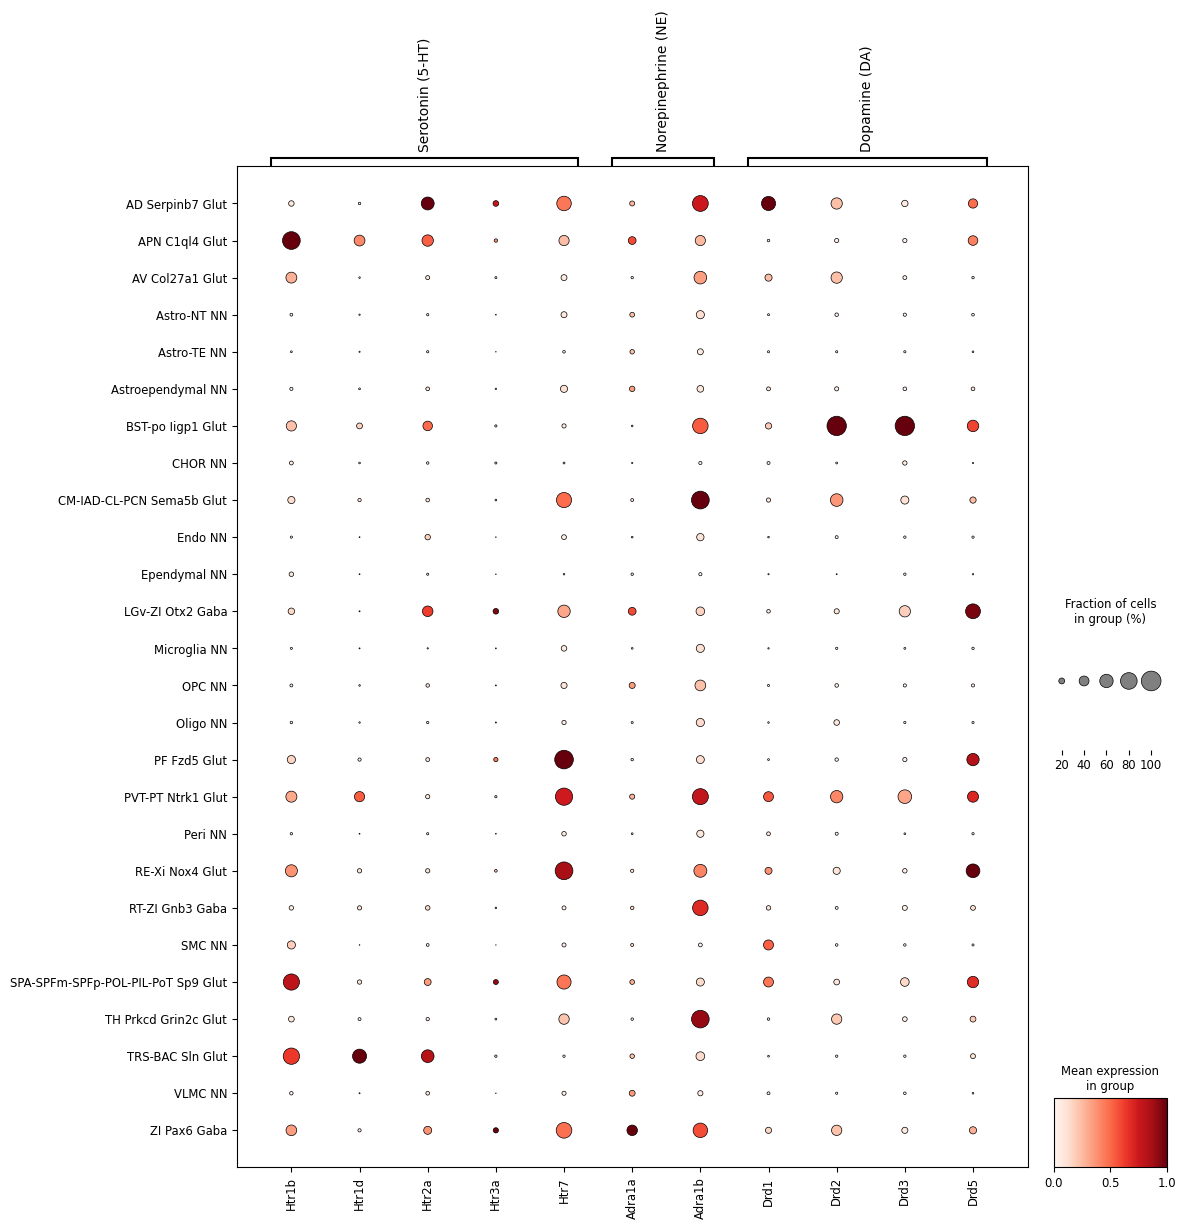

Saved: dotplot_TH_MERFISH_receptors_by_subclass.png


In [10]:
receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

dp = sc.pl.dotplot(
    adata_th,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_TH_MERFISH_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_TH_MERFISH_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertypes with >= 30 cells: 60


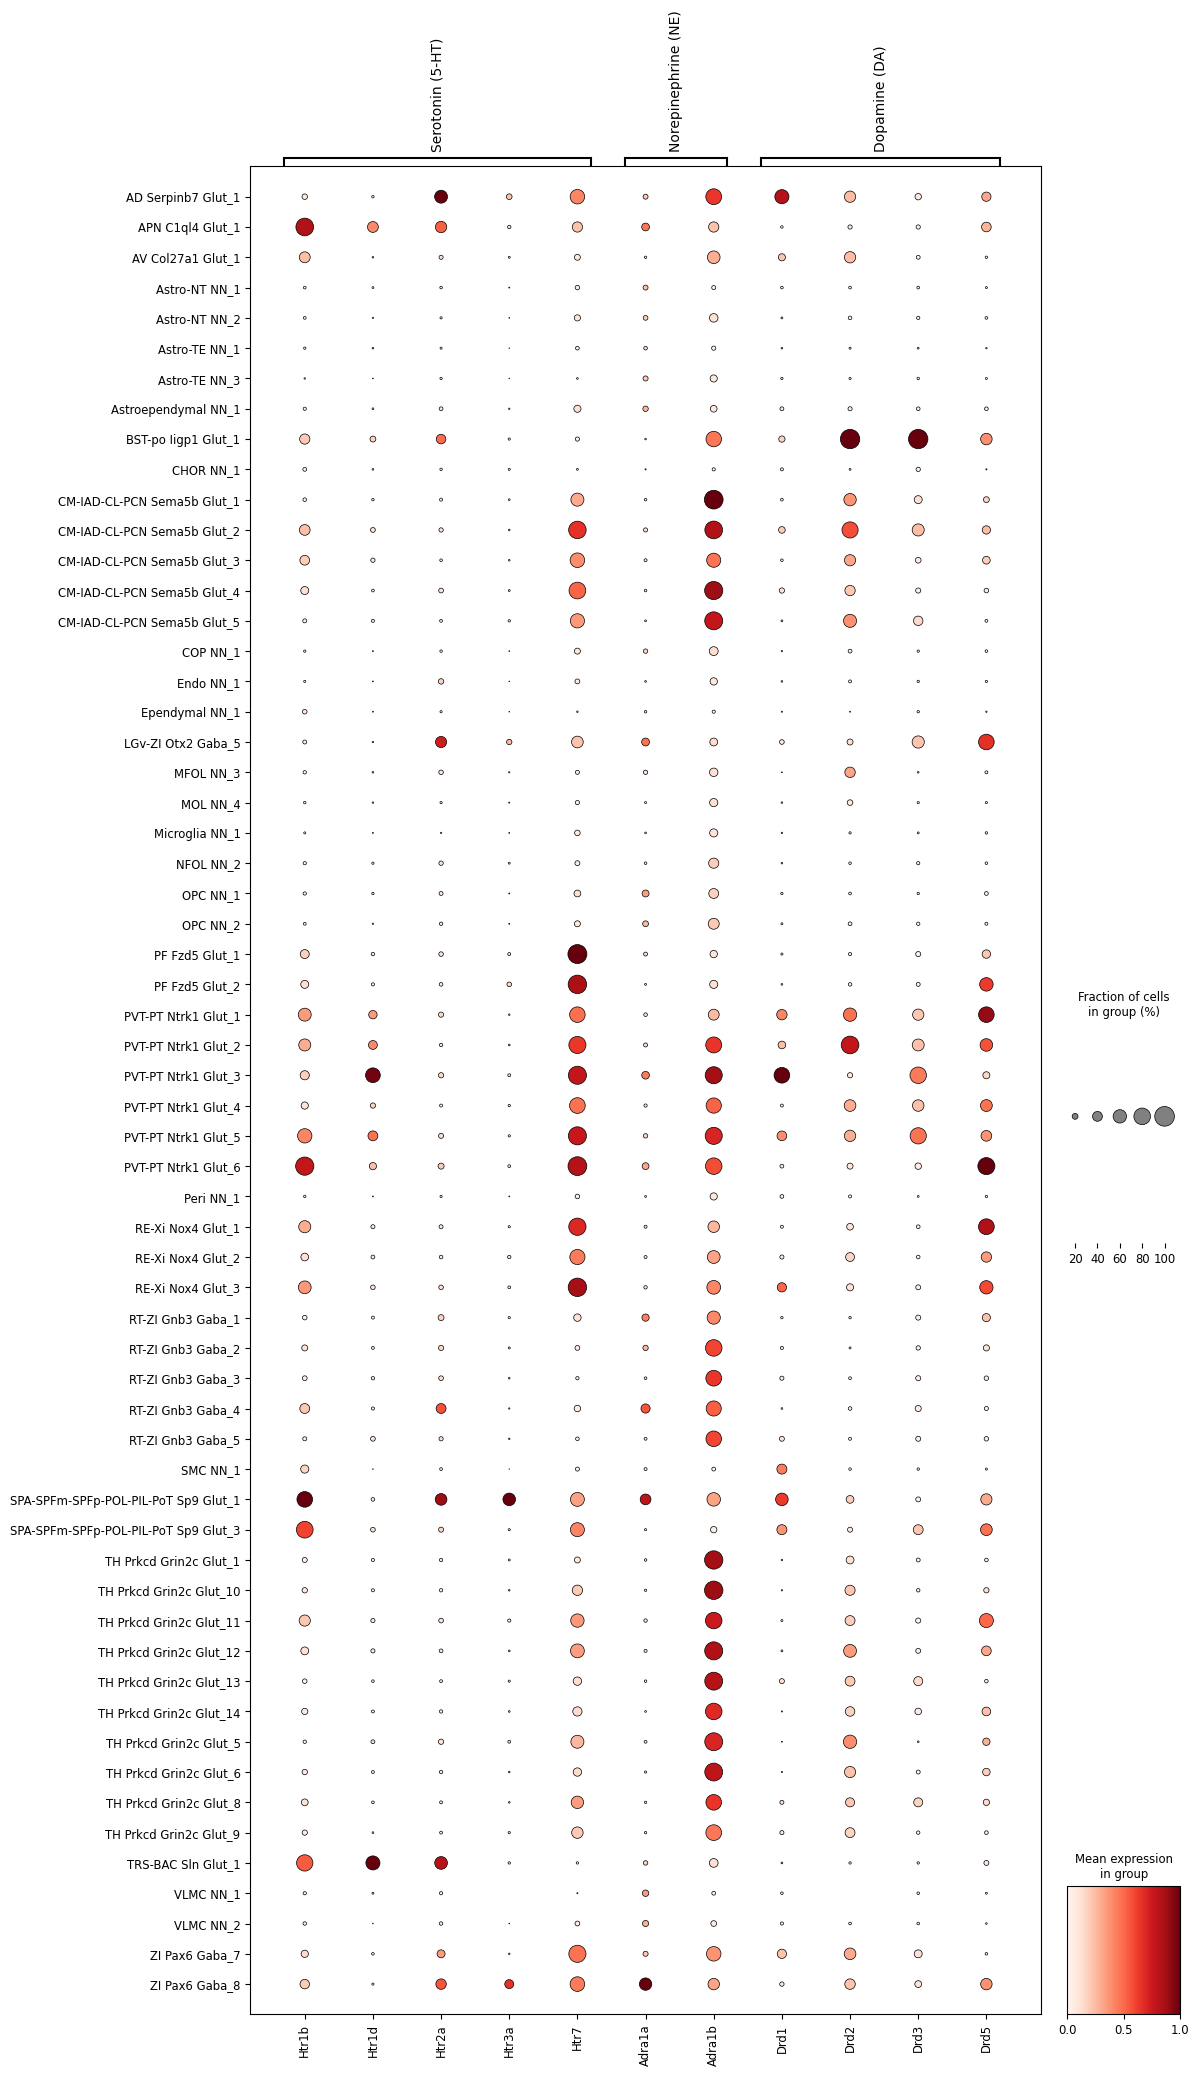

Saved: dotplot_TH_MERFISH_receptors_by_supertype.png


In [11]:
min_cells = 30
supertype_counts = adata_th.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_th[adata_th.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_st * 0.4)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_TH_MERFISH_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_TH_MERFISH_receptors_by_supertype.png")

## 9. By Thalamic Nucleus

Show receptor expression for each cell type broken down by thalamic nucleus,
to reveal nucleus-specific expression patterns.

Cell type x nucleus groups (>= 30 cells): 132
  Astro-NT NN (RT): 1,211
  Astro-TE NN (RT): 516
  Astroependymal NN (RT): 35
  Endo NN (RT): 796
  Microglia NN (RT): 122
  OPC NN (RT): 253
  Oligo NN (RT): 3,433
  Peri NN (RT): 206
  RT-ZI Gnb3 Gaba (RT): 6,830
  SMC NN (RT): 44
  VLMC NN (RT): 58
  ZI Pax6 Gaba (RT): 56
  AD Serpinb7 Glut (AD): 1,036
  APN C1ql4 Glut (PF): 31
  AV Col27a1 Glut (AD): 60
  AV Col27a1 Glut (AV): 1,212
  BST-po Iigp1 Glut (AM): 45
  CM-IAD-CL-PCN Sema5b Glut (MD): 1,248
  CM-IAD-CL-PCN Sema5b Glut (PVT): 439
  CM-IAD-CL-PCN Sema5b Glut (CM): 607
  CM-IAD-CL-PCN Sema5b Glut (IMD): 169
  CM-IAD-CL-PCN Sema5b Glut (IAD): 184
  CM-IAD-CL-PCN Sema5b Glut (IAM): 51
  CM-IAD-CL-PCN Sema5b Glut (CL): 287
  CM-IAD-CL-PCN Sema5b Glut (PCN): 52
  CM-IAD-CL-PCN Sema5b Glut (Xi): 31
  PF Fzd5 Glut (MD): 570
  PF Fzd5 Glut (PVT): 112
  PF Fzd5 Glut (PF): 1,818
  PF Fzd5 Glut (CL): 240
  PF Fzd5 Glut (PCN): 161
  PVT-PT Ntrk1 Glut (MD): 351
  PVT-PT Ntrk1 Glut (PVT): 2,

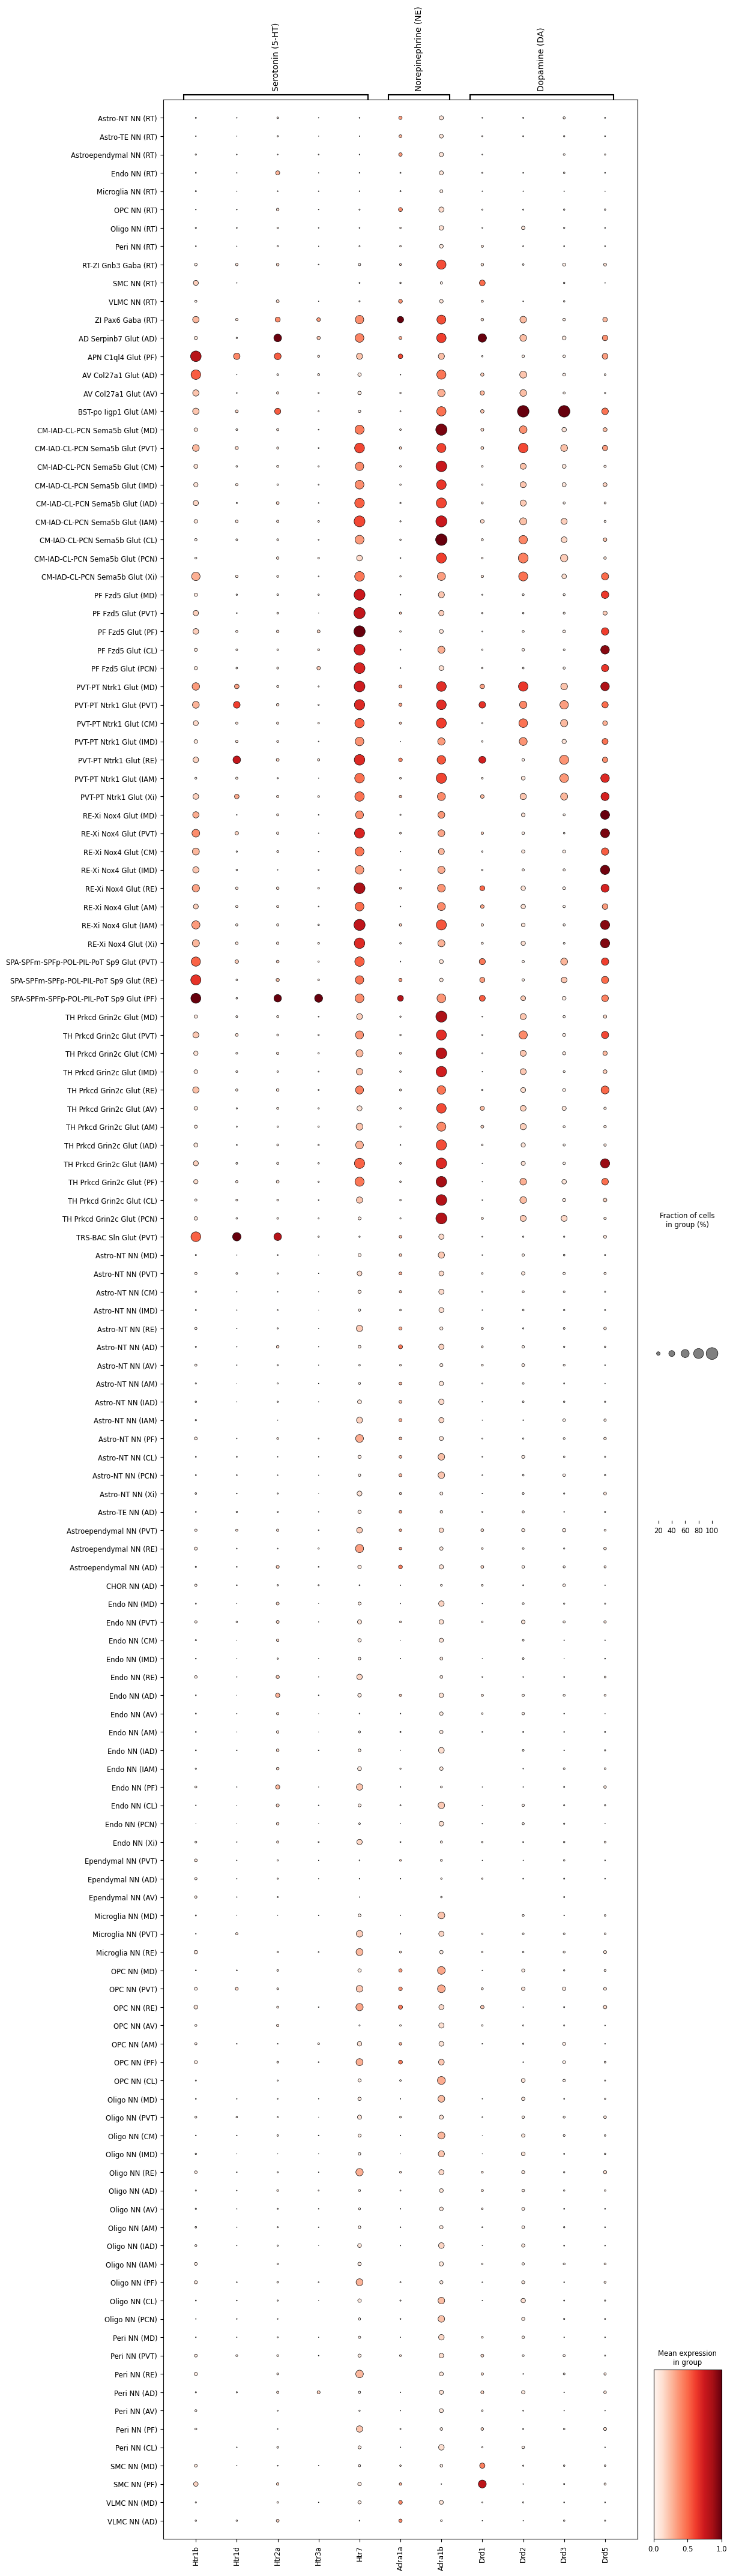

Saved: dotplot_TH_MERFISH_receptors_by_nucleus.png


In [12]:
# Create nucleus-level grouping
adata_th.obs['cell_type_nucleus'] = (
    adata_th.obs['subclass_short'].astype(str) + ' (' +
    adata_th.obs['parcellation_structure'].astype(str) + ')'
)

group_counts = adata_th.obs.groupby('cell_type_nucleus', observed=True).size()
valid_groups = group_counts[group_counts >= 30].index.tolist()
adata_nuc = adata_th[adata_th.obs['cell_type_nucleus'].isin(valid_groups)].copy()

# Sort by cell class then nucleus
def sort_key(name):
    parts = name.rsplit(' (', 1)
    sc = parts[0]
    nuc = parts[1].rstrip(')') if len(parts) > 1 else ''
    # GABAergic (RT) first, then excitatory thalamic, then glia
    if 'Gaba' in sc or nuc == 'RT':
        cat = 0
    elif 'NN' in sc:
        cat = 2
    else:
        cat = 1
    nuc_order = {'MD': 0, 'PVT': 1, 'CM': 2, 'IMD': 3, 'RE': 4,
                 'AD': 5, 'AV': 6, 'AM': 7, 'IAD': 8, 'IAM': 9,
                 'RT': 10, 'PF': 11, 'CL': 12, 'PCN': 13, 'Xi': 14}
    return (cat, sc, nuc_order.get(nuc, 99))

sorted_groups = sorted(valid_groups, key=sort_key)
adata_nuc.obs['cell_type_nucleus'] = pd.Categorical(
    adata_nuc.obs['cell_type_nucleus'], categories=sorted_groups, ordered=True
)

n_groups = len(sorted_groups)
print(f"Cell type x nucleus groups (>= 30 cells): {n_groups}")
for g in sorted_groups:
    print(f"  {g}: {group_counts[g]:,}")

dp3 = sc.pl.dotplot(
    adata_nuc,
    var_names=receptor_groups,
    groupby='cell_type_nucleus',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(8, n_groups * 0.4)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_TH_MERFISH_receptors_by_nucleus.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_TH_MERFISH_receptors_by_nucleus.png")

## 10. MD Substructure Breakdown (MDc, MDl, MDm)

Compare receptor expression across mediodorsal nucleus subdivisions.

MD substructure groups (>= 20 cells): 14
  Astro-NT NN (MD): 1,390
  Astroependymal NN (MD): 20
  CM-IAD-CL-PCN Sema5b Glut (MD): 1,248
  Endo NN (MD): 844
  Microglia NN (MD): 105
  OPC NN (MD): 171
  Oligo NN (MD): 1,226
  PF Fzd5 Glut (MD): 570
  PVT-PT Ntrk1 Glut (MD): 351
  Peri NN (MD): 160
  RE-Xi Nox4 Glut (MD): 37
  SMC NN (MD): 55
  TH Prkcd Grin2c Glut (MD): 3,382
  VLMC NN (MD): 55


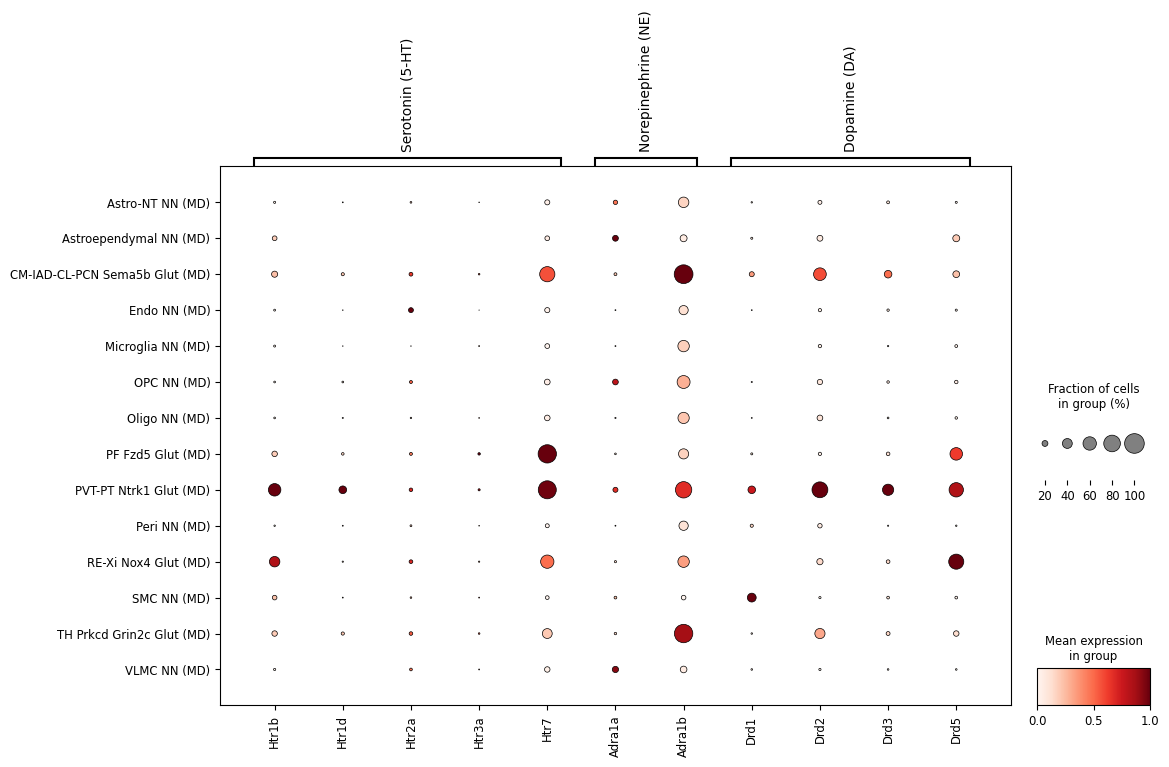

Saved: dotplot_TH_MERFISH_MD_substructure.png


In [13]:
# Filter to MD cells only
md_mask = adata_th.obs['parcellation_structure'] == 'MD'
adata_md = adata_th[md_mask].copy()

if len(adata_md) >= 50:
    adata_md.obs['cell_type_md'] = (
        adata_md.obs['subclass_short'].astype(str) + ' (' +
        adata_md.obs['parcellation_substructure'].astype(str) + ')'
    )
    
    md_group_counts = adata_md.obs.groupby('cell_type_md', observed=True).size()
    md_valid = md_group_counts[md_group_counts >= 20].index.tolist()
    
    if len(md_valid) >= 3:
        adata_md_sub = adata_md[adata_md.obs['cell_type_md'].isin(md_valid)].copy()
        
        def md_sort(name):
            parts = name.rsplit(' (', 1)
            sc = parts[0]
            sub = parts[1].rstrip(')') if len(parts) > 1 else ''
            sub_order = {'MDc': 0, 'MDl': 1, 'MDm': 2}
            return (sc, sub_order.get(sub, 9))
        
        md_sorted = sorted(md_valid, key=md_sort)
        adata_md_sub.obs['cell_type_md'] = pd.Categorical(
            adata_md_sub.obs['cell_type_md'], categories=md_sorted, ordered=True
        )
        
        n_md = len(md_sorted)
        print(f"MD substructure groups (>= 20 cells): {n_md}")
        for g in md_sorted:
            print(f"  {g}: {md_group_counts[g]:,}")
        
        dp4 = sc.pl.dotplot(
            adata_md_sub,
            var_names=receptor_groups,
            groupby='cell_type_md',
            standard_scale='var',
            cmap='Reds',
            figsize=(12, max(6, n_md * 0.5)),
            show=False,
            return_fig=True
        )
        dp4.style(dot_edge_color='black', dot_edge_lw=0.5)
        dp4.savefig('dotplot_TH_MERFISH_MD_substructure.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved: dotplot_TH_MERFISH_MD_substructure.png")
    else:
        print(f"Insufficient MD substructure groups ({len(md_valid)}) for plotting")
else:
    print(f"Insufficient MD cells ({len(adata_md)}) for substructure analysis")

## 11. Summary Statistics

In [14]:
expr_df = pd.DataFrame(
    adata_th.X,
    index=adata_th.obs.index,
    columns=adata_th.var.index
)
expr_df['subclass'] = adata_th.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 70)
print("Mean Expression (log2) by Thalamic Subclass — MERFISH")
print("=" * 70)
display(mean_expr.round(2))

print("\n" + "=" * 70)
print("Fraction of Expressing Cells by Thalamic Subclass — MERFISH")
print("=" * 70)
display(frac_expr.round(3))

Mean Expression (log2) by Thalamic Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
AD Serpinb7 Glut,0.19,0.05,0.95,0.18,0.99,0.15,1.36,1.05,0.58,0.23,0.51
APN C1ql4 Glut,1.94,0.41,0.51,0.10,0.54,0.31,0.53,0.06,0.14,0.11,0.46
AV Col27a1 Glut,0.58,0.03,0.11,0.04,0.19,0.05,0.67,0.28,0.58,0.10,0.05
Astro-NT NN,0.07,0.02,0.05,0.01,0.22,0.14,0.32,0.04,0.09,0.08,0.06
Astro-TE NN,0.04,0.02,0.05,0.01,0.07,0.13,0.21,0.04,0.05,0.05,0.04
Astroependymal NN,0.09,0.04,0.11,0.03,0.30,0.19,0.25,0.12,0.12,0.10,0.11
BST-po Iigp1 Glut,0.49,0.18,0.48,0.05,0.13,0.04,1.00,0.23,2.38,3.17,0.63
CHOR NN,0.12,0.04,0.06,0.05,0.05,0.03,0.10,0.08,0.04,0.14,0.03
CM-IAD-CL-PCN Sema5b Glut,0.29,0.08,0.09,0.03,1.05,0.06,1.78,0.12,0.87,0.40,0.28



Fraction of Expressing Cells by Thalamic Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
AD Serpinb7 Glut,0.183,0.063,0.572,0.191,0.668,0.161,0.750,0.645,0.477,0.224,0.368
APN C1ql4 Glut,0.871,0.452,0.484,0.097,0.419,0.290,0.419,0.065,0.129,0.129,0.387
AV Col27a1 Glut,0.456,0.034,0.122,0.048,0.204,0.060,0.557,0.259,0.480,0.116,0.062
Astro-NT NN,0.075,0.028,0.055,0.015,0.207,0.151,0.310,0.048,0.102,0.090,0.070
Astro-TE NN,0.042,0.024,0.055,0.010,0.068,0.140,0.205,0.051,0.052,0.054,0.039
Astroependymal NN,0.088,0.041,0.110,0.030,0.260,0.180,0.238,0.116,0.124,0.108,0.108
BST-po Iigp1 Glut,0.418,0.200,0.382,0.055,0.127,0.036,0.727,0.218,0.982,0.982,0.491
CHOR NN,0.114,0.038,0.063,0.051,0.044,0.025,0.089,0.082,0.044,0.133,0.025
CM-IAD-CL-PCN Sema5b Glut,0.262,0.095,0.107,0.040,0.707,0.080,0.876,0.130,0.554,0.305,0.218
